
## Préparation des données et des modèles


In [34]:

## Importation des librairies et des modules nécessaires

import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

from sklearn import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import regex as re
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import torch



## Chargement et préparation des données


In [35]:

### Chargement des données par chunks

print("Début du chargement des données...")
df = pd.read_csv('EFREI - LIPSTIP - 50k elements EPO.csv', chunksize=10000)
print("Chargement des données terminé.")

df_list = []
for chunk in tqdm(df, desc="Chargement des chunks"):
    df_list.append(chunk)

df = pd.concat(df_list)
print("Concaténation des chunks terminée.")


Début du chargement des données...
Chargement des données terminé.


Chargement des chunks: 5it [01:10, 14.19s/it]

Concaténation des chunks terminée.


In [36]:

### Sélection des colonnes nécessaires et nettoyage des données

df_2 = df.drop(columns=['Date d\'application', 'Numero de publication', 'date de publication', 'IPC'])
print("Colonnes inutiles supprimées.")

def clean_xml(xml_text):
    if not xml_text:
        return []
    xml_text = re.sub(r'<!--.*?-->', '', xml_text, flags=re.DOTALL)
    xml_text = re.sub(r'<[^>]+>', '', xml_text, flags=re.DOTALL)
    xml_text = re.sub(r'</?p[^>]*>', '', xml_text, flags=re.DOTALL)
    paragraphs = xml_text.split('\n')
    essential_info = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]
    return essential_info

if df_2['description'].isnull().values.any():
    print("Il y a des valeurs nulles dans la colonne 'description'.")
    df_2['description'] = df_2['description'].fillna('')

print("Début de l'extraction des informations essentielles...")
df_2['infos_essentielles'] = df_2['description'].apply(clean_xml)
print("Extraction des informations essentielles terminée.")

print(df_2.head(50))


Colonnes inutiles supprimées.
Début de l'extraction des informations essentielles...
Extraction des informations essentielles terminée.


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




## Analyse des codes CPC


In [37]:

### Vérification des premières lettres des codes CPC

all_first_letters = set()

for cpc_list in df_2['CPC']:
    cpc_list = eval(cpc_list)
    if isinstance(cpc_list, list):
        for code in cpc_list:
            if len(code) > 0:
                all_first_letters.add(code[0])

all_first_letters = sorted(list(all_first_letters))

print("Toutes les lettres possibles en tant que premières lettres des codes CPC :", all_first_letters)


Toutes les lettres possibles en tant que premières lettres des codes CPC : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']


In [38]:

### Statistiques des premières lettres des codes CPC

letter_indices = {letter: [] for letter in all_first_letters}

for i, cpc_list in enumerate(df_2['CPC']):
    cpc_list = eval(cpc_list)
    if isinstance(cpc_list, list):
        for code in cpc_list:
            if len(code) > 0:
                letter_indices[code[0]].append(i)

letter = 'Y'
letter_count = len(letter_indices[letter])
total_count = df_2.shape[0]
letter_percentage = (letter_count / total_count) * 100
print(f"Nombre de brevets avec la première lettre '{letter}': {letter_count} ({letter_percentage:.2f}%)")

print("Nombre de lignes :", df_2.shape)


Nombre de brevets avec la première lettre 'Y': 9636 (19.27%)
Nombre de lignes : (50000, 5)


In [39]:

### Analyse du nombre de mots dans les descriptions

def count_words(text):
    if isinstance(text, list):
        text = ' '.join(text)
    return len(text.split())

first_row_words_count = count_words(df_2['infos_essentielles'].iloc[0])
print("Nombre de mots dans la première ligne de la colonne 'infos_essentielles':", first_row_words_count)


Nombre de mots dans la première ligne de la colonne 'infos_essentielles': 8581



## Utilisation de PatentBERT pour obtenir des embeddings


In [40]:

### Chargement du tokenizer et du modèle PatentBERT

tokenizer = AutoTokenizer.from_pretrained('anferico/bert-for-patents')
bert_model = AutoModel.from_pretrained('anferico/bert-for-patents')

# Utiliser le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)


D:\PycharmProjects\MasterCamp\MastercampTDProjet\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(39859, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [45]:

### Sélection d'un échantillon de données pour le test

sample_df = df_2.head(1000).copy()

def get_bert_embeddings(text_list, batch_size=10, max_length=512):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = bert_model(**encoded_input)
        batch_embeddings = model_output.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

sample_texts = sample_df['description'].tolist()
embeddings = get_bert_embeddings(sample_texts, batch_size=10, max_length=512)

sample_df.loc[:, 'embeddings'] = list(embeddings)

print(sample_df.head())


   Numéro d'application                                                                                                                                                                                CPC  \
0              17167919  ['B23K26-361', 'H04M1-0266', 'B23K26-402', 'G06F1-1626', 'G06F1-1656', 'G06F1-1637', 'G02F1-133308', 'B23K2101-34', 'B23K2101-40', 'B23K2103-42', 'B23K2103-172', 'G02F1-133331']   
1              17166775                                               ['A61B17-68', 'A61B17-888', 'A61B17-8685', 'A61B17-864', 'A61B17-8605', 'A61B17-8635', 'A61B17-863', 'A61B17-8891', 'A61B2017-8655']   
2              17166069                                                                                                                                                        ['D06F58-206', 'D06F58-20']   
3              18771363                                                                                                                ['H01P1-2138', 'H01P5-107', 'H01P1-2088',

In [46]:

### Extraction des étiquettes à partir des codes CPC

def extract_first_letter(cpc_list):
    if isinstance(cpc_list, str):
        try:
            cpc_list = eval(cpc_list)
        except Exception as e:
            print(f"Error evaluating CPC list: {e}")
            return ''
    if isinstance(cpc_list, list) and len(cpc_list) > 0:
        for code in cpc_list:
            if code[0] == 'Y':
                return 'Y'
        return cpc_list[0][0]
    return ''

sample_df['label'] = sample_df['CPC'].apply(extract_first_letter)

print("Étiquettes extraites :", sample_df['label'].unique())


Étiquettes extraites : ['B' 'A' 'D' 'H' 'F' 'Y' 'C' 'G' 'E']


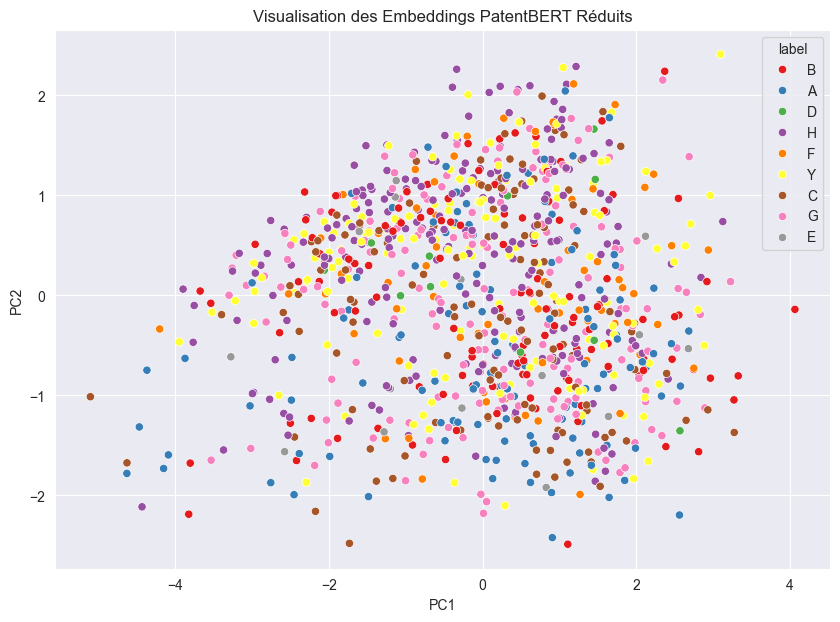

In [47]:

### Visualisation des embeddings réduits

reduced_embeddings = PCA(n_components=2).fit_transform(np.array(sample_df['embeddings'].tolist()))

embedding_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
embedding_df['label'] = sample_df['label']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=embedding_df, x='PC1', y='PC2', hue='label', palette='Set1')
plt.title('Visualisation des Embeddings PatentBERT Réduits')
plt.show()



## Entraînement et évaluation du modèle de régression logistique


In [48]:

### Préparation des données pour la régression logistique

X = np.array(sample_df['embeddings'].tolist())
y = sample_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [53]:

### Entraînement du modèle de régression logistique

log_reg_model = LogisticRegression(max_iter=2000, solver='saga')
log_reg_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=2000, solver='saga')

In [50]:

### Évaluation du modèle

y_pred = log_reg_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

           A       0.68      0.77      0.72        22
           B       0.63      0.43      0.51        28
           C       0.66      0.84      0.74        25
           D       0.00      0.00      0.00         2
           E       1.00      0.00      0.00         3
           F       0.36      0.45      0.40        11
           G       0.68      0.73      0.70        26
           H       0.84      0.76      0.80        54
           Y       0.47      0.52      0.49        29

    accuracy                           0.65       200
   macro avg       0.59      0.50      0.48       200
weighted avg       0.66      0.65      0.64       200



In [51]:

### Vérification de la distribution des classes dans l'ensemble de données complet

all_labels = df_2['CPC'].apply(extract_first_letter)
print(all_labels.value_counts())


CPC
H    10680
G     9242
Y     6754
B     6499
A     5974
C     5758
F     3602
E      946
D      545
Name: count, dtype: int64
